<a href="https://colab.research.google.com/github/Jectrianama/python-gcpds.Local_biplot/blob/main/docs/source/notebooks/01-module%20example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Local Biplot Examples**

In [24]:
!pip install datashader bokeh holoviews   --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.4 MB/s eta 0:00:00


In [27]:
from sklearn.datasets import make_swiss_roll
#se ilustra nuevamente sobre swiss roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)


## Uniform Manifold Approximation and Projection (UMAP) Fundamentals

![gifumap](https://umap-learn.readthedocs.io/en/latest/_images/aligned_umap_pendigits_anim.gif)

- UMAP es una técnica de reducción de dimensión que modela el espacio de alta dimensión como estructura topológica difusa y la optimiza en el espacio de baja dimensión preservando distancias globales y locales.

- UMAP construye un grafo ponderado para representar la estructura topológica difusa.

- La probabilidad $p_{nn'}$ que representa el peso del borde entre $\mathbf{x}_n$ and $\mathbf{x}_{n'}$ esta dada por:

\begin{equation}
p_{nn'} = \exp\left(-\frac{\|\mathbf{x}_n - \mathbf{x}_{n'}\| - \rho_n}{\sigma_n}\right),
\end{equation}

- $\rho_n$ es la distancia al vecino más cercano de $\mathbf{x}_n$, lo que asegura que las distancias locales no se ven afectadas por ruido.
    
- $\sigma_n$ se determina por una un número fijo de vecinos.


- La relación difusa se vuelve simétrica como:

\begin{equation}
\tilde{p}_{nn'} = p_{nn'} + p_{n'n} - p_{nn'} p_{n'n}.
\end{equation}



- Las relaciones en el espacio de baja dimensión se fijan mediante una distribución t-student de cola pesada:

\begin{equation}
q_{nn'} = \left(1 + a \|\mathbf{z}_n - \mathbf{z}_{n'}\|^{2b}\right)^{-1},
\end{equation}

con $a$ y $b$ como parámetros de la distribución. Generalmente se fijan en 1.


- UMAP minimiza la entropía cruzada :

\begin{equation}
C(P;Q) = \sum_{n \neq n'} \left( -\tilde{p}_{nn'} \log(q_{nn'}) - (1 - \tilde{p}_{nn'}) \log(1 - q_{nn'}) \right).
\end{equation}

- Convencionalmente se utilizan métodos de gradiente para resolver la optimización.

In [25]:
import umap
import umap.plot

In [28]:
red = umap.UMAP(n_components=2,n_neighbors=40, min_dist=0.2)
X_reduced_umap = red.fit_transform(X)

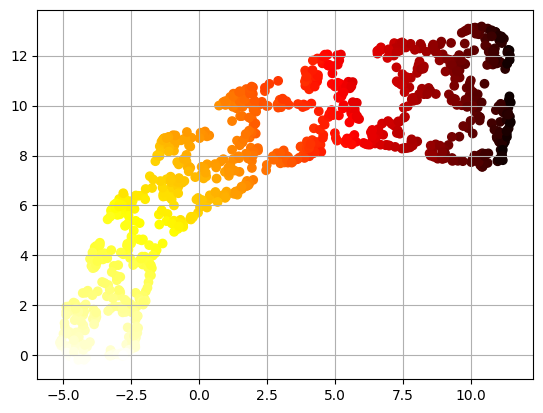

In [29]:
plt.scatter(X_reduced_umap[:, 0], X_reduced_umap[:, 1], c=t, cmap=plt.cm.hot)
plt.grid(True)
plt.show()


- UMAP presenta una serie de métodos para [gráficos interactivos](https://umap-learn.readthedocs.io/en/latest/plotting.html)

<Axes: >

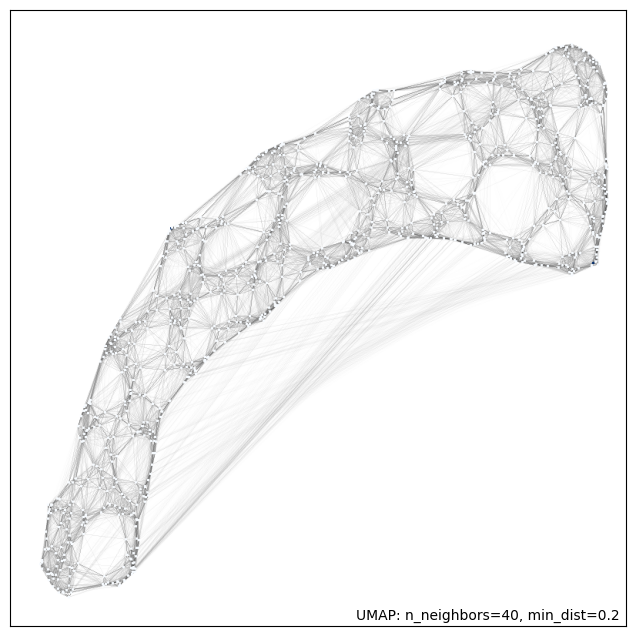

In [30]:
umap.plot.connectivity(red, show_points=True)

<Axes: >

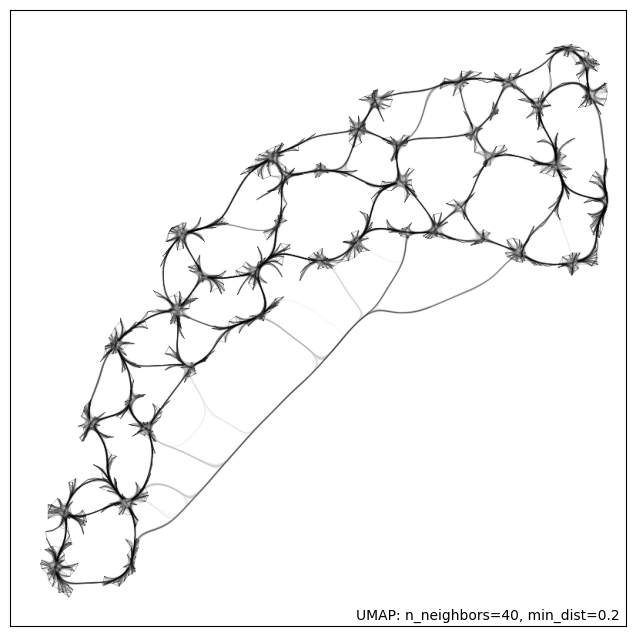

In [31]:
umap.plot.connectivity(red, edge_bundling='hammer')

# Installing our Local Biplot Library

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.localbiplot.git --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.1 MB/s eta 0:00:00


## Agregando todolo necesario para ejecutar nuestro codigo

Agregamos la librerias necesarias como numpy, pandas  y scikit learn.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib as mpl



from sklearn.preprocessing import StandardScaler, MinMaxScaler

Una vez  descargada la libreria procedemos a utilizarla dentro de nuestro codigo.


In [ ]:
import gcpds.localbiplot as lb


# **Multivariate Gaussians**

We create a  data matrix $\mathbf{X} \in ℝ^{N \times P}$  by creating three clouds of 500 samples and 5 features each, following a multi normal or Gaussian distribution whose mean and covariance matrix are previously defined. The covariance matrix must be positive semi definite.

In [4]:



def generate_samples(mean, covariance, num_samples=500, standardize=True):
        """
        Generate random samples based on mean and covariance.

        Parameters:
        - mean: list | np.ndarray
          1-D array_like, of length N. Mean of the N-dimensional distribution.

        - covariance: list | np.ndarray
          2-D array_like, of shape (N, N)
          Covariance matrix of the distribution. It must be symmetric and positive-semidefinite for proper sampling.
        - num_samples: int | tuple of ints
        - standardize: Whether to standardize the generated samples. Default is True.

        Returns: list | np.ndarray
        - samples:
          Drawn samples, of shape size, if that was provided. If not, the shape is (N,)
        Generated samples.
        """

        np.random.seed(123)
        samples = np.random.default_rng(seed=123).multivariate_normal(mean, covariance, num_samples)

        if standardize:
            scaler = MinMaxScaler()
            samples = scaler.fit_transform(samples)

        return samples






## Sample Generation:

For each cluster, the `generate_samples()` function is used to generate `n_samples` from a multivariate normal distribution, defined by the corresponding mean and covariance for that cluster. The resulting data is stored in the `data` array.

In [5]:
# Parameters
n_samples = 500
n_features = 5
n_clusters = 3

np.random.seed(123)

# Initialize empty array for the data
data = np.zeros((n_samples * n_clusters, n_features))


mean_5 = [[0.1, 0.05, 22.2, 92.4, 102],
         [12.3,  23.8,  12.2, 14.4, 10],
         [-12.3, 15.8, 9.2, -9.4, 9],]


covariance_5 = [[[3.    , 2.45  , 0.84  , 0.12  , 0.68  ],
                [2.45  , 2.25  , 0.    , 0.162 , 0.102 ],
                [0.84  , 0.    , 1.    , 0.36  , 0.034 ],
                [0.12  , 0.162 , 0.36  , 1.44  , 0.0816],
                [0.68  , 0.102 , 0.034 , 0.0816, 2.89  ]],


                  [[7.0, -5, 2, -5.2, -0.1],
                  [-5,  3.5, -0.4, -0.3, -0.2],
                  [2, -0.4, 3.0, -0.2, -0.1],
                  [-5.2, -0.3, -0.2, 5.0, -0.1],
                  [-0.1, -0.2, -0.1, -0.1, 8.0]],


                [[8.,    0.2   , -1.6   , -2.352 , -3.0 ],
                [0.2,   2.25  , 1.2   , 1.62  , 2.295 ],
                [-1.6,    1.2   , 6.    , 0.84  , 1.564 ],
                [-2.352,  -1.62  , 0.84  , 4.44  , 2.0],
                [-3.0 , 2.295 , -1.564 , 2.0, 3.89  ]]]



# Define mean and covariance for each cluster
for i in range(n_clusters):

    cluster_data =  generate_samples(mean_5[i], covariance_5[i], standardize=False)
    #print(np.cov(cluster_data.T) )
    data[i * n_samples:(i + 1) * n_samples, :] = cluster_data



## Target Variable Generation:
A target variable `ydata` is created to label the samples by their respective clusters. It assigns a unique label (0, 1, or 2) to the samples based on which cluster they belong to.

In [6]:
#target variable generation
class_synth = 3
nc = 500
ydata = np.empty(shape=[nc*class_synth],dtype=np.int8)
for i in range(class_synth):
  ydata[i*nc :(i+1)*nc] = i

Convert the generated data into a DataFrame with feature columns 'f1' to 'f5'

In [7]:
#convertir datos a Dataframe
Xdata = pd.DataFrame(data, columns=['f1', 'f2','f3', 'f4', 'f5' ])

print(Xdata.shape, ydata.shape)

(1500, 5) (1500,)



## Instantiating the Local Biplot Class

We instantiate the `LocalBiplot` class, which will be used to perform both global and local biplot analyses. The class is configured with an affine transformation (rotation) and UMAP as the dimensionality reduction method.


In [8]:
localbiplot = lb.LocalBiplot(affine_='rotation',redm='umap')


## Global Biplot Analysis using PCA

The global biplot is generated using PCA (Principal Component Analysis). It projects the data into a 2D plane, showing relationships between features and the clusters in the dataset.

variance explained: [0.84775919 0.13367759 0.0118387  0.00553754 0.00118698]
Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')


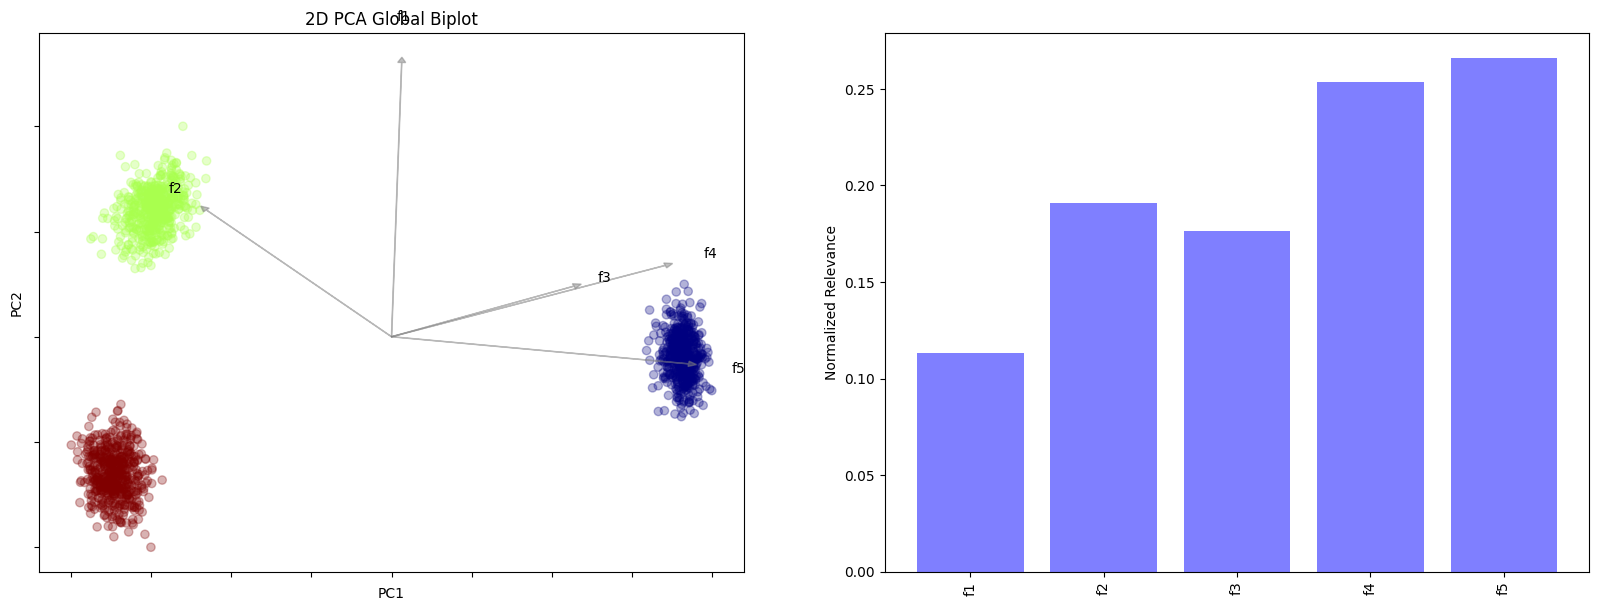

In [9]:
loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=ydata,loading_labels=Xdata.columns)


## Local Biplot Analysis using UMAP

Then, we perform a local biplot analysis using UMAP (Uniform Manifold Approximation and Projection).


Dimensionality Reduction...
Affine Transformation...
1/3
(500, 5)
variance explained: [0.41675491 0.22420651 0.2185841  0.12468377 0.01577072]
plot 1-th group
Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')
Saving figure synth_local_bip
2/3
(500, 5)
variance explained: [0.39552911 0.23471258 0.17886436 0.13707245 0.05382149]
plot 2-th group
Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')
Saving figure synth_local_bip
3/3
(500, 5)
variance explained: [0.44720821 0.22011799 0.20531436 0.11685426 0.01050519]
plot 3-th group
Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')
Saving figure synth_local_bip


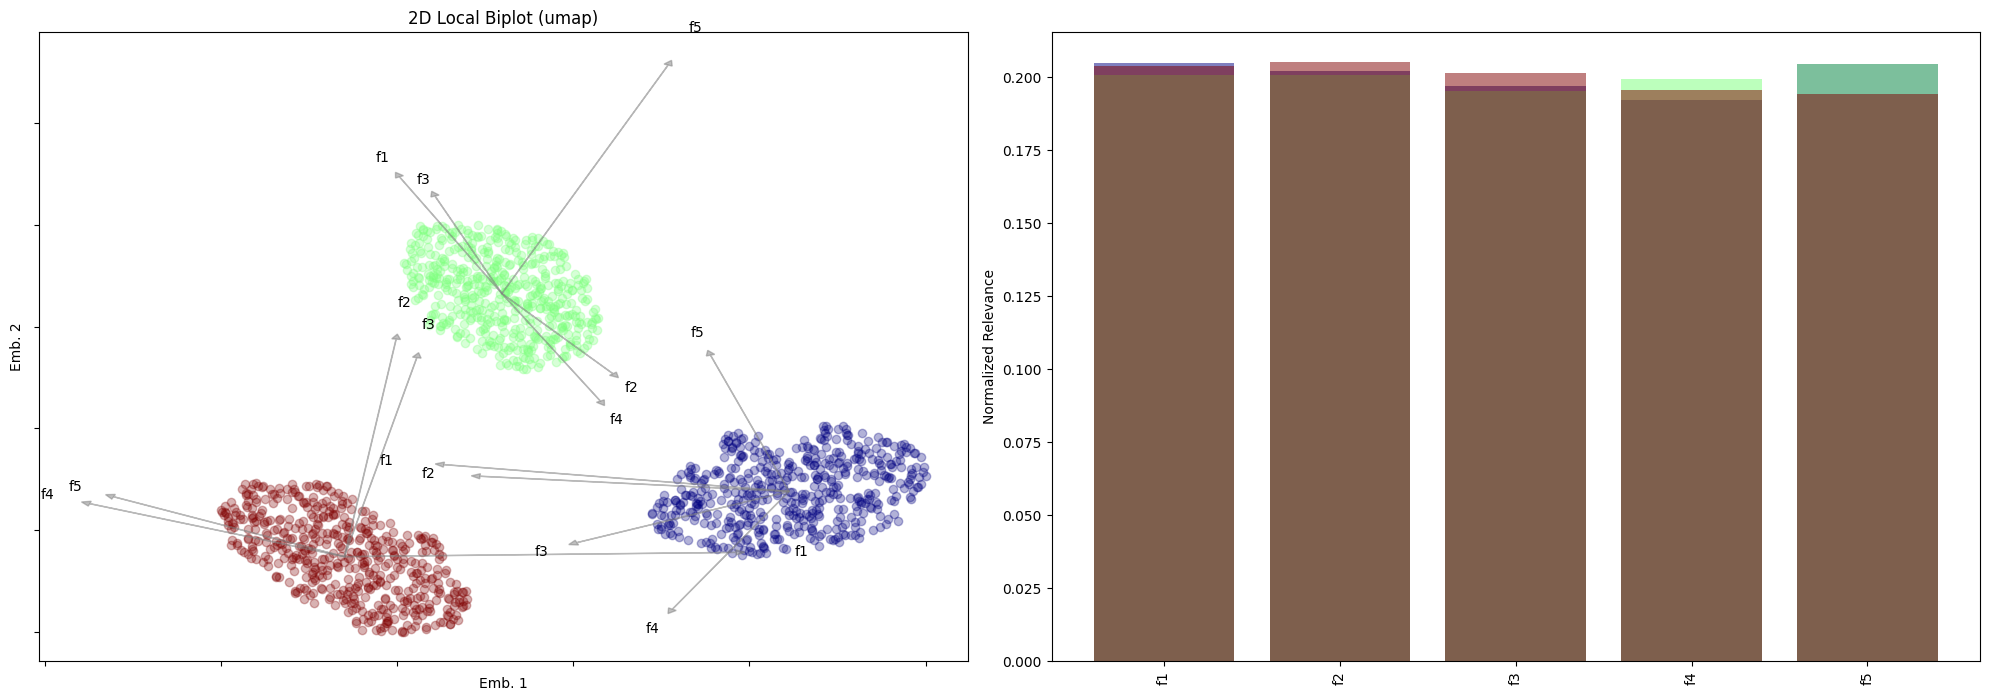

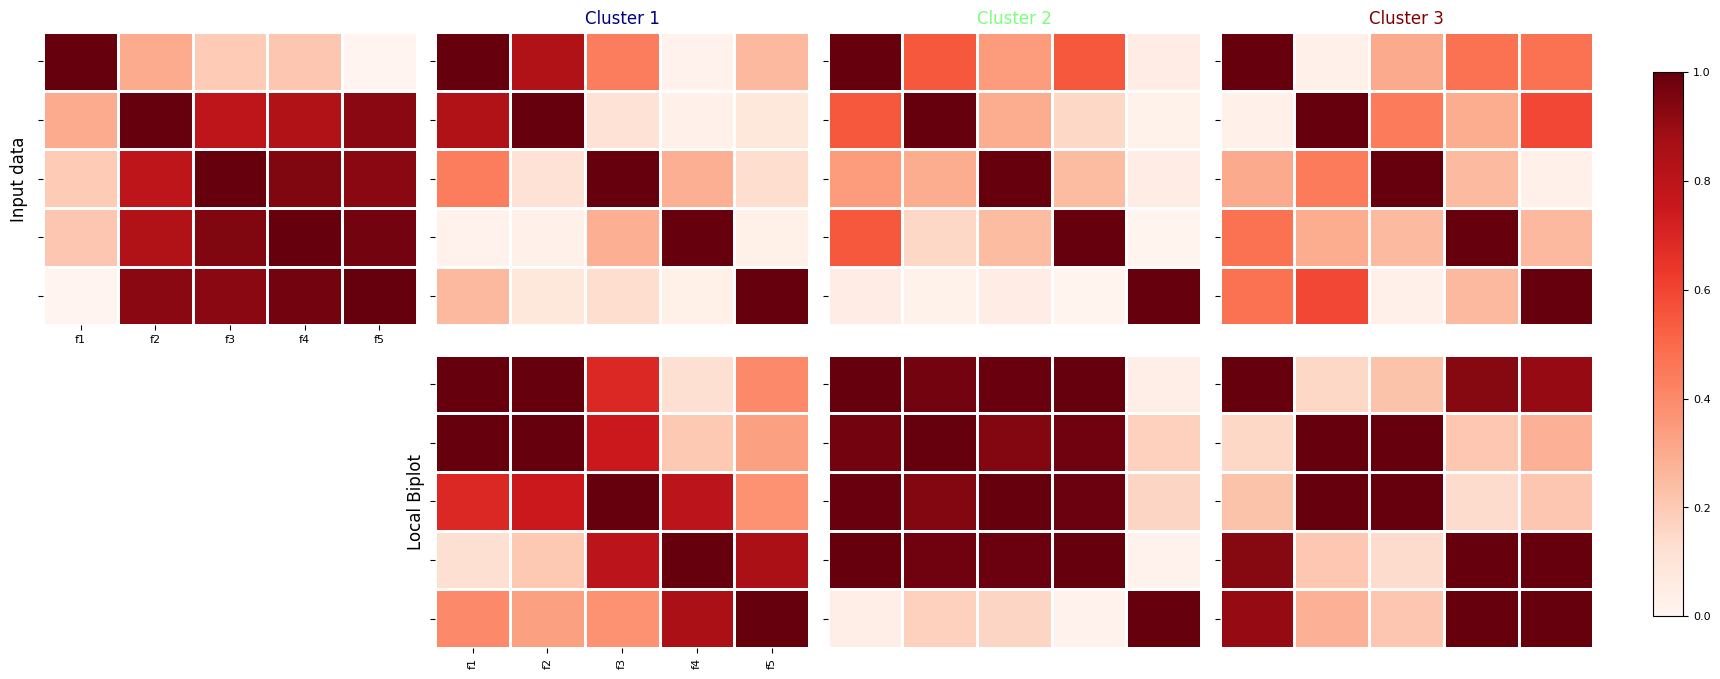

array([0, 0, 0, ..., 2, 2, 2], dtype=int8)

In [10]:
localbiplot.local_biplot2D(Xdata,y=ydata,plot_=True,loading_labels=Xdata.columns,  filename="synth_local_bip")

# **Forage Grasses Dataset**

* This database comprises 35 distinct VIs from five color spaces: RGB, CIE 1976 L*a*b*(CIELab), CIE 1976 L*u*v*(CIELuv), hue-saturation-value (HSV), and hue-saturation-lightness (HSL), for three categories of forage grass:
festuca arundinacea (Fa), diploid Lolium perenne (Lp2n), and tetraploid Lolium perenne (Lp4n).

* From the thermal data, Δ𝑇 and the crop water stress index (CWSI) were calculated.
* A breeder score is provided for three distinct dates designated as T2, T4, and T5. The score ranges from one to nine, based on both biomass quantity and the verdant hue of the plant.
* $𝑃=37$  features and $𝑁=3174$  samples are obtained.



#Download grass database

In [22]:
# Repository details
repo_url = "https://github.com/Jectrianama/Datasets_biplot.git"
repo_name = "Datasets_biplot"

# Check if the repository directory already exists
if not os.path.exists(repo_name):
    # Clone the repository if it doesn't exist (suppress verbose output)
    !git clone -l -s $repo_url > /dev/null 2>&1

# Unzip the dataset (suppress verbose output)
!unzip -o /content/Datasets_biplot/PhenotypingData.zip > /dev/null 2>&1

# Path to the CSV file
csv_path = '/content/PhenotypingData.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(csv_path, sep=';')


#Rename and remove some dataframe columns

In [13]:
#data.info()
data.rename(columns={'FamKloon':'Famclone', 'Soort': 'Variety', 'GR_Rat':'G/R', 'Hue_val': 'H',
       'S_val' : 'S', 'V_val' : 'V', 'L_val' : 'L', 'a_val' : 'a*', 'b_val':'b*', 'I_val':'I' ,
       'G_R': 'G-R', 'G_B' : 'G-B', 'u_val': 'u*', 'v_val': 'v*'}, inplace=True)
data.drop(columns= ['Famclone', 'Code'	], inplace=True)#

In [14]:
# Suponiendo que Data_sel es un DataFrame de pandas
mapping = {

    130716: 1,
    130828: 2,
    130906: 3
}

data['Date'].replace(mapping, inplace=True)

replacing varieties 'Fa', 'Lp2n', 'Lp4n' to  1, 2, 3

In [15]:
data['Variety'].replace(['Fa', 'Lp2n', 'Lp4n'],
                        [1, 2, 3], inplace=True)


data = data.dropna().reset_index(drop=True)

data.loc[:,'CWSI'] += 0.0005 #esta columna tiene datos en ceros

In [16]:
data = data[['Date', 'Variety', 'Rkap',  'R', 'G', 'B', 'RCC', 'GCC', 'BCC','ExG', 'ExG2', 'ExR','ExGR', 'GRVI', 'GBVI', 'BRVI', 'G/R', 'G-R', 'G-B', 'VDVI', 'VARI', 'MGRVI', 'CIVE', 'VEG','WI', 'H', 'S', 'V', 'I',  'L', 'a*', 'b*', 'ab', 'NDLab', 'u*', 'v*','uv', 'NDLuv','dT', 'CWSI','Score']]

In [17]:

date= data['Date']

Xdata = data.iloc[:, 3:41].copy()

ydata = data['Score']



## Instantiating the Local Biplot Class

We instantiate the `LocalBiplot` class, which will be used to perform both global and local biplot analyses. The class is configured with an affine transformation (rotation) and UMAP as the dimensionality reduction method.


In [18]:
localbiplot = lb.LocalBiplot(affine_='rotation',redm='umap')

In [19]:
#loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=ydata,loading_labels=Xdata.columns, filename="grass_classic_bip")

## Local Biplot Analysis using UMAP
Then, we perform a local biplot analysis using UMAP (Uniform Manifold Approximation and Projection).

The `local_biplot2D` method includes an optional parameter `corrplot`, which is set to `True` by default. When enabled, it displays a correlation plot between all features, providing insight into how features are related to each other in the biplot. In this case, we have explicitly set `corrplot=False` to avoid displaying the correlation plot.  


Dimensionality Reduction...
Performing clustering...
(3174,) - [0 1 2 3]
Affine Transformation...
1/4
(651, 38)
variance explained: [5.19871801e-01 2.34846121e-01 1.70186370e-01 5.48736209e-02
 1.55434479e-02 2.74644884e-03 1.14178767e-03 3.91118519e-04
 2.39631110e-04 9.16536949e-05 3.15005695e-05 2.66756070e-05
 7.56034320e-06 1.05437192e-06 7.60602621e-07 1.96080844e-07
 1.36325725e-07 5.46285640e-08 3.33884856e-08 1.27773443e-08
 9.99472057e-09 3.51631755e-09 8.21008622e-10 1.84701666e-10
 7.61062405e-11 9.27730191e-12 2.18081304e-12 4.22188180e-13
 8.57117977e-17 5.35247035e-17 3.99149800e-17 1.80411056e-17
 1.36691949e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
plot 1-th group
Index(['R', 'G', 'B', 'RCC', 'GCC', 'BCC', 'ExG', 'ExG2', 'ExR', 'ExGR',
       'GRVI', 'GBVI', 'BRVI', 'G/R', 'G-R', 'G-B', 'VDVI', 'VARI', 'MGRVI',
       'CIVE', 'VEG', 'WI', 'H', 'S', 'V', 'I', 'L', 'a*', 'b*', 'ab', 'NDLab',
       'u*', 'v*', 'uv', 'NDLuv', 'dT', '

UnboundLocalError: local variable 'fig3' referenced before assignment

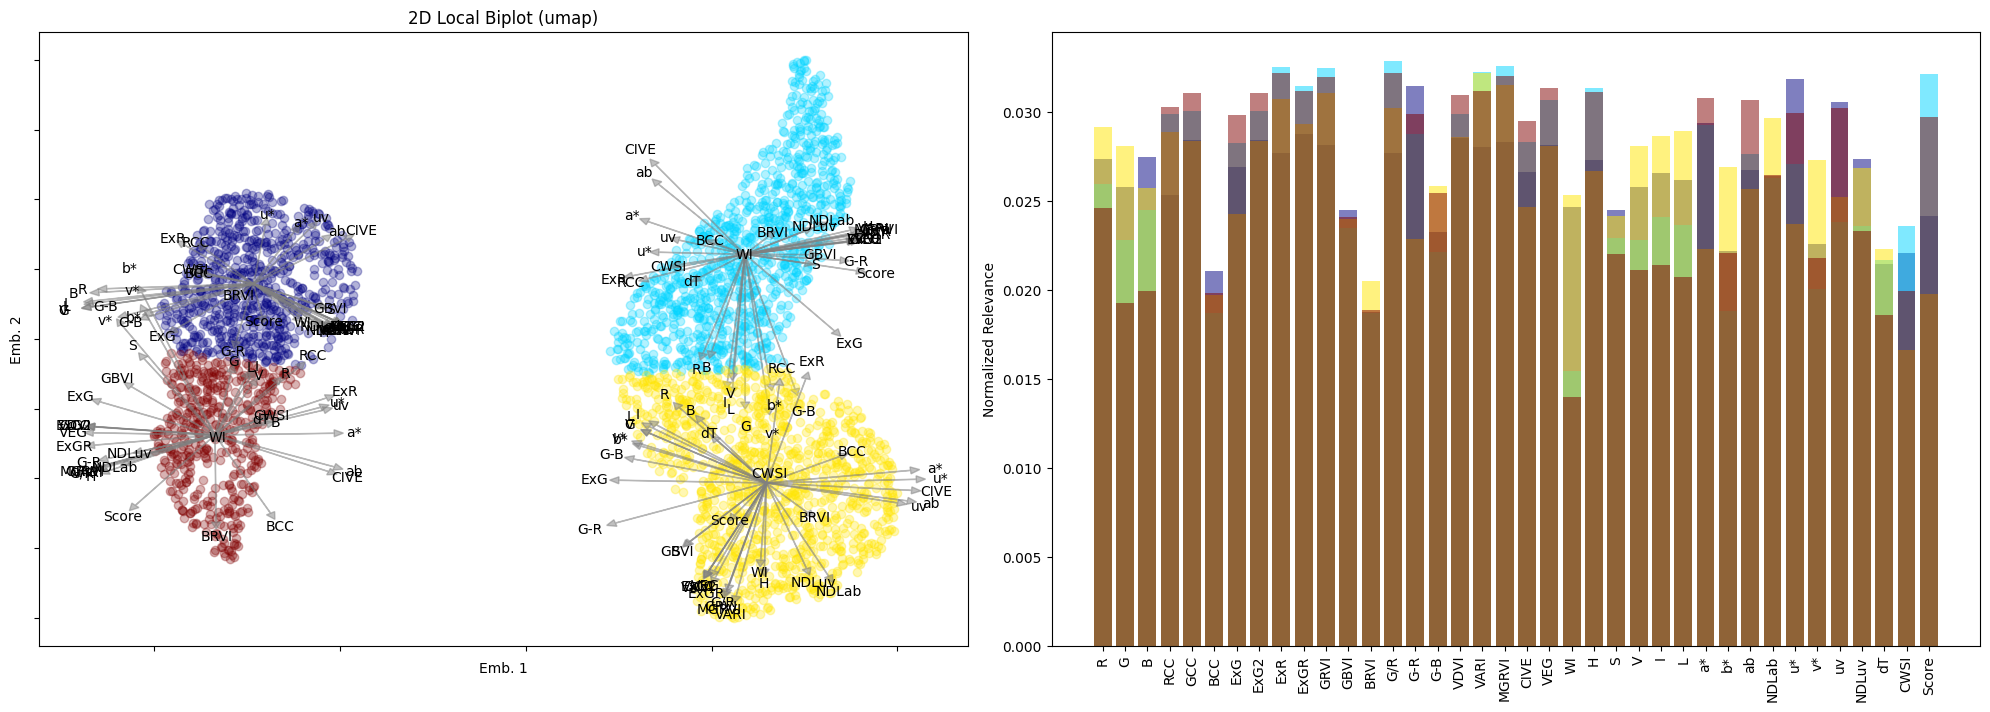

In [21]:
group = localbiplot.local_biplot2D(Xdata,y=4,plot_=True, corrplot_=False, loading_labels=Xdata.columns, filename="grass_local_bip")


## Global Biplot Analysis using PCA

The global biplot is generated using PCA (Principal Component Analysis). It projects the data into a 2D plane, showing relationships between features and the clusters in the dataset.

In [ ]:
loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=group,loading_labels=Xdata.columns, filename="grass_classic_bip")

In [ ]:

#global pca biplot
#loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=ydata,loading_labels=Xdata.columns, filename="grass_classic_bip")

#local biplot
group = localbiplot.local_biplot2D(Xdata,y=4,plot_=True, corrplot=False, loading_labels=Xdata.columns, filename="grass_local_bip")
#global pca biplot
loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=group,loading_labels=Xdata.columns, filename="grass_classic_bip")




In [ ]:
C_ = len(np.unique(ydata))
cmap_ = mpl.colormaps['jet'].resampled(C_)
cmap_ = cmap_(range(C_))
plt.figure(figsize =(9,5))
plt.scatter(localbiplot.Zr[:,0],localbiplot.Zr[:,1], c=ydata, cmap='jet', alpha=0.6, marker='.')

plt.yticks([])
plt.xticks([])
plt.xlabel('PC1', fontsize=25)
plt.ylabel('PC2', fontsize=25)
cbar = plt.colorbar()
tick_font_size = 25
cbar.ax.tick_params(labelsize=tick_font_size)
plt.tight_layout()
plt.savefig('umap_score.pdf', bbox_inches='tight', dpi=300)
plt.show()